In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

RANDOM_STATE = 42

In [7]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
X.sample(5, random_state=RANDOM_STATE)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
204,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,0.06373,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,0.05461,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,0.05796,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,0.07102,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,0.06782,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


In [5]:
print(f"Tailles : X={X.shape} - Y={Y.shape}")
X.describe().T.head(10)

Tailles : X=(569, 30) - Y=(569,)


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
mean compactness,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
mean concavity,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
mean concave points,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
mean symmetry,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744


In [ ]:
from locale import normalize


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

((455, 30),
 (114, 30),
 1    285
 0    170
 Name: count, dtype: int64,
 1    0.631579
 0    0.368421
 Name: proportion, dtype: float64)

In [ ]:
from sklearn.pipeline import _name_estimators

models = {}

models['DecisionTree'] = DecisionTreeClassifier(max_depth=4, random_state=RANDOM_STATE)
models['RandomForest'] = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1)
models['XGBoost'] = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.9, random_state=RANDOM_STATE,
    eval_metric='logloss')

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name}: entrainé")

DecisionTree: entrainé
RandomForest: entrainé
XGBoost: entrainé


In [14]:
def evaluate(model, X_tr, y_tr, X_te, y_te):
    y_pred = model.predict(X_te)

    metrics = {
        'accuracy': accuracy_score(y_te, y_pred),
        'precision': precision_score(y_te, y_pred),
        'recall': recall_score(y_te, y_pred),
        'f1': f1_score(y_te, y_pred),
    }

    return metrics

results = {}
for name, model in models.items():
    results[name] = evaluate(model, X_train, y_train, X_test, y_test)

pd.DataFrame(results).T

,accuracy,precision,recall,f1
DecisionTree,0.938596,0.957746,0.944444,0.951049
RandomForest,0.956140,0.958904,0.972222,0.965517
XGBoost,0.956140,0.946667,0.986111,0.965986


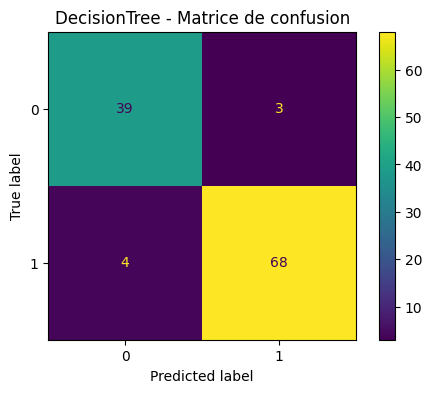

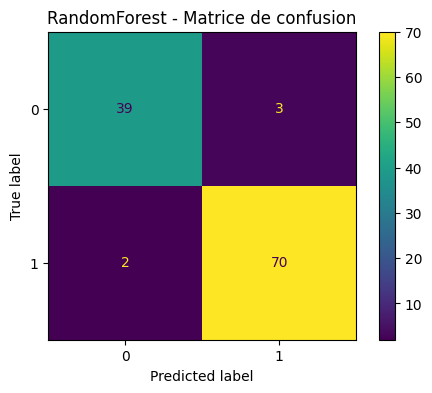

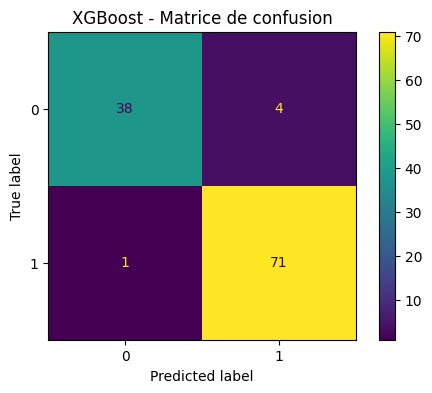

In [27]:
for name, model in models.items():
    fig, ax = plt.subplots(figsize=(6,4))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)
    ax.set_title(f"{name} - Matrice de confusion")
    plt.show()

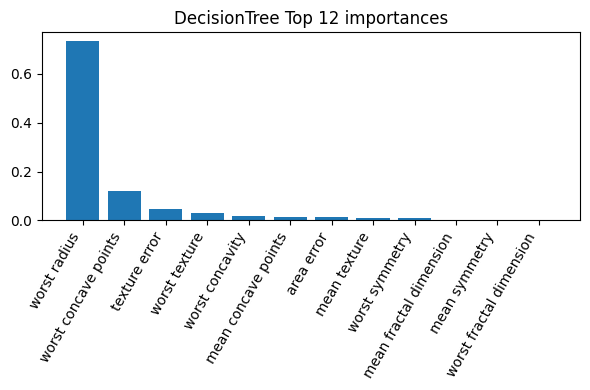

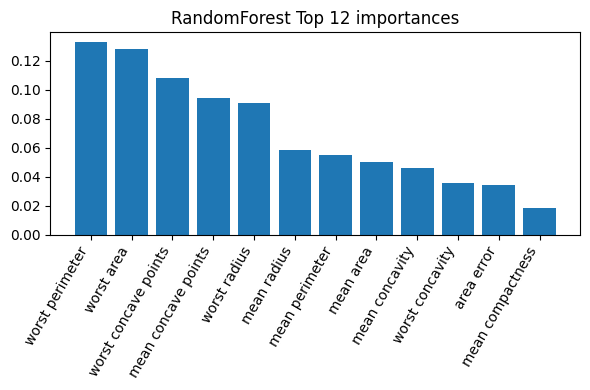

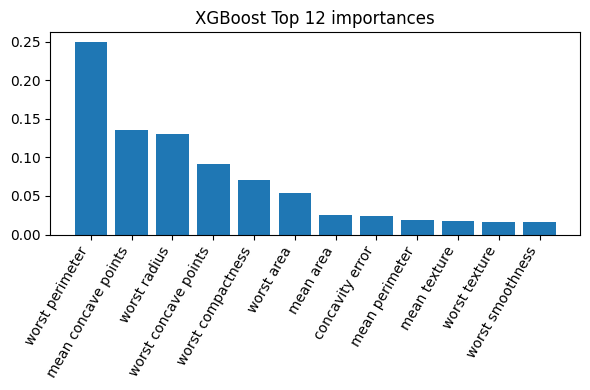

In [26]:
def plot_feature_importances(model, feature_names, top=12, model_name=""):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:top]
    #print(importances[idx])
    plt.figure(figsize=(6,4))
    plt.bar(range(len(idx)), importances[idx])
    plt.xticks(range(len(idx)), np.array(feature_names)[idx], rotation=60, ha='right')

    plt.title(f"{model_name} Top {top} importances")
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    model
    plot_feature_importances(model, X.columns, top=12, model_name=name)